<a href="https://colab.research.google.com/github/osmarbolivar/bol_povertymap/blob/main/PredictingPoverty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [224]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import gmean

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. Data**

All features are positively correlated with the target variable, because the latter is: $\text{Target variable} = 1- \text{Poverty rate}$

In [225]:
raw = pd.read_excel('/content/drive/MyDrive/Research/Poverty by Community (Bolivar and Mendez)/identifiers.xlsx', index_col=0)
raw_2012 = pd.read_excel('/content/drive/MyDrive/Research/Poverty by Community (Bolivar and Mendez)/raw_2012.xlsx', index_col=0)
test = pd.read_excel('/content/drive/MyDrive/Research/Poverty by Community (Bolivar and Mendez)/test.xlsx', index_col=0)

## **2. Training**

In [226]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [227]:
train, validation = train_test_split(raw_2012, test_size=0.4, random_state=0)

# Apply Z-score normalization to the variables in the training set only
scaler = StandardScaler()
train_scaled = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index=train.index)

# Use the same scaler to transform the validation and test sets based on the mean and standard deviation of the training set
validation_scaled = pd.DataFrame(scaler.transform(validation), columns=validation.columns, index=validation.index)
test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns, index=test.index)

X_train = train_scaled.drop('pobre', axis=1)
y_train = train_scaled['pobre']

# Use the model to make predictions on the validation set
X_val = validation_scaled.drop('pobre', axis=1)
y_val = validation_scaled['pobre']

X_test = test_scaled.drop('pobre', axis=1)

### Ridge

Before tuning:  
MSE: 10.772
MAE: 0.745
R^2: -8.870

In [228]:
from sklearn.linear_model import Ridge

# Instantiate Ridge model
#ridge = Ridge()
ridge = Ridge(alpha=20.541173483530642, positive=True)

# Fit Ridge on training set
ridge.fit(X_train, y_train)

# Realizar predicciones en el conjunto de validación
y_pred_train = ridge.predict(X_train)
# Calcular las métricas de error en el conjunto de validación
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_train_final_ridge = y_pred_train
for i in range(y_pred_train.shape[0]):
  y_pred_train[i] = (y_pred_train[i] * train.std()[0]) + train.mean()[0]

# Realizar predicciones en el conjunto de validación
y_pred_val = ridge.predict(X_val)
# Calcular las métricas de error en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

y_val_final_ridge = y_pred_val
for i in range(y_pred_val.shape[0]):
  y_pred_val[i] = (y_pred_val[i] * train.std()[0]) + train.mean()[0]

# Imprimir los resultados
print("\nMétricas de error:")
print(f"MSE train: {mse_train:.3f}")
print(f"MAE train: {mae_train:.3f}")
print(f"R^2 train: {r2_train:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")
print(f"R^2: {r2_val:.3f}")


Métricas de error:
MSE train: 0.693
MAE train: 0.680
R^2 train: 0.307
MSE: 0.856
MAE: 0.727
R^2: 0.215


In [229]:
y_pred_test = ridge.predict(X_test)

y_test_final_ridge = y_pred_test
for i in range(y_pred_test.shape[0]):
  y_pred_test[i] = (y_pred_test[i] * train.std()[0]) + train.mean()[0]

In [230]:
# Get the coefficients from the Ridge model
coef = ridge.coef_
# Create a dataframe of feature importances
feature_importance_ridge = pd.DataFrame({'Feature': X_train.columns, 'Importance': coef})
# Sort the features by importance
feature_importance_ridge = feature_importance_ridge.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance_ridge.columns = ['feat', 'imp_ridge']
# Print the feature importances
feature_importance_ridge

,feat,imp_ridge
0,cp,0.403601
1,schools,0.211721
2,ci,0.186444
3,primary,0.094138
4,luz_mean,0.067008
5,crops,0.033117
6,hospitals,0.000000
7,banks,0.000000
8,zonurb,0.000000
9,asenta,0.000000


### Lasso

Before tuning:  
MSE: 1.092
MAE: 0.883
R^2: -0.000

In [231]:
from sklearn.linear_model import Lasso

# Define the Lasso model with default parameters
#lasso = Lasso()
lasso = Lasso(alpha=0.05, positive=True)

# Fit the model on the training set
lasso.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_pred_train = lasso.predict(X_train)
# Calcular las métricas de error en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_train_final_lasso = y_pred_train
for i in range(y_pred_train.shape[0]):
  y_pred_train[i] = (y_pred_train[i] * train.std()[0]) + train.mean()[0]

# Realizar predicciones en el conjunto de validación
y_pred_val = lasso.predict(X_val)
# Calcular las métricas de error en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Desnormalizar las predicciones en el conjunto de validación
y_val_final_lasso = y_pred_val
for i in range(y_pred_val.shape[0]):
  y_pred_val[i] = (y_pred_val[i] * train.std()[0]) + train.mean()[0]


# Imprimir los resultados
print("\nMétricas de error:")
print(f"MSE train: {mse_train:.3f}")
print(f"MAE train: {mae_train:.3f}")
print(f"R^2 train: {r2_train:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")
print(f"R^2: {r2_val:.3f}")


Métricas de error:
MSE train: 0.703
MAE train: 0.692
R^2 train: 0.297
MSE: 0.847
MAE: 0.736
R^2: 0.224


In [232]:
y_pred_test = lasso.predict(X_test)

y_test_final_lasso = y_pred_test
for i in range(y_pred_test.shape[0]):
  y_pred_test[i] = (y_pred_test[i] * train.std()[0]) + train.mean()[0]

In [233]:
# Get the coefficients from the Ridge model
coef = lasso.coef_
# Create a dataframe of feature importances
feature_importance_lasso = pd.DataFrame({'Feature': X_train.columns, 'Importance': coef})
# Sort the features by importance
feature_importance_lasso = feature_importance_lasso.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance_lasso.columns = ['feat', 'imp_lasso']
# Print the feature importances
feature_importance_lasso

,feat,imp_lasso
0,cp,0.356960
1,schools,0.195435
2,ci,0.151804
3,primary,0.083596
4,luz_mean,0.043975
5,hospitals,0.000000
6,banks,0.000000
7,zonurb,0.000000
8,asenta,0.000000
9,crops,0.000000


### ElasticNet

Before tuning:   
MSE: 1.092
MAE: 0.883
R^2: -0.000

In [234]:
from sklearn.linear_model import ElasticNet

# Define the ElasticNet model
#elastic_net = ElasticNet()
elastic_net = ElasticNet(alpha=0.05, l1_ratio=0.05, positive=True)

# Fit the ElasticNet model to the training data
elastic_net.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_pred_train = elastic_net.predict(X_train)
# Calcular las métricas de error en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_train_final_enet = y_pred_train
for i in range(y_pred_train.shape[0]):
  y_pred_train[i] = (y_pred_train[i] * train.std()[0]) + train.mean()[0]

# Realizar predicciones en el conjunto de validación
y_pred_val = elastic_net.predict(X_val)
# Calcular las métricas de error en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Desnormalizar las predicciones en el conjunto de validación
y_val_final_enet = y_pred_val
for i in range(y_pred_val.shape[0]):
  y_pred_val[i] = (y_pred_val[i] * train.std()[0]) + train.mean()[0]

# Imprimir los resultados
print("\nMétricas de error:")
print(f"MSE train: {mse_train:.3f}")
print(f"MAE train: {mae_train:.3f}")
print(f"R^2 train: {r2_train:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")
print(f"R^2: {r2_val:.3f}")


Métricas de error:
MSE train: 0.694
MAE train: 0.681
R^2 train: 0.306
MSE: 0.853
MAE: 0.728
R^2: 0.218


In [235]:
y_pred_test = elastic_net.predict(X_test)

y_test_final_enet = y_pred_test
for i in range(y_pred_test.shape[0]):
  y_pred_test[i] = (y_pred_test[i] * train.std()[0]) + train.mean()[0]

In [236]:
# Get the coefficients from the Ridge model
coef = elastic_net.coef_
# Create a dataframe of feature importances
feature_importance_en = pd.DataFrame({'Feature': X_train.columns, 'Importance': coef})
# Sort the features by importance
feature_importance_en = feature_importance_en.sort_values('Importance', ascending=False).reset_index(drop=True)
feature_importance_en.columns = ['feat', 'imp_en']
# Print the feature importances
feature_importance_en

,feat,imp_en
0,cp,0.395230
1,schools,0.206575
2,ci,0.179956
3,primary,0.095666
4,luz_mean,0.068342
5,crops,0.031041
6,hospitals,0.000000
7,banks,0.000000
8,zonurb,0.000000
9,asenta,0.000000


### Decision Tree Regressor

Before tuning:   
MSE: 0.244
MAE: 0.377
R^2: 0.776

In [237]:
from sklearn.tree import DecisionTreeRegressor

# Define the model with default parameters
#dt_reg = DecisionTreeRegressor()
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=3, min_samples_leaf=4, min_samples_split=13)

# Fit the model to the data
dt_reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_pred_train = dt_reg.predict(X_train)
# Calcular las métricas de error en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_train_final_dt = y_pred_train
for i in range(y_pred_train.shape[0]):
  y_pred_train[i] = (y_pred_train[i] * train.std()[0]) + train.mean()[0]

# Realizar predicciones en el conjunto de validación
y_pred_val = dt_reg.predict(X_val)
# Calcular las métricas de error en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Desnormalizar las predicciones en el conjunto de validación
y_val_final_dt = y_pred_val
for i in range(y_pred_val.shape[0]):
  y_pred_val[i] = (y_pred_val[i] * train.std()[0]) + train.mean()[0]

# Imprimir los resultados
print("\nMétricas de error en el conjunto de validación:")
print(f"MSE train: {mse_train:.3f}")
print(f"MAE train: {mae_train:.3f}")
print(f"R^2 train: {r2_train:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")
print(f"R^2: {r2_val:.3f}")


Métricas de error en el conjunto de validación:
MSE train: 0.132
MAE train: 0.284
R^2 train: 0.868
MSE: 0.132
MAE: 0.288
R^2: 0.879


In [238]:
y_pred_test = dt_reg.predict(X_test)

y_test_final_dt = y_pred_test
for i in range(y_pred_test.shape[0]):
  y_pred_test[i] = (y_pred_test[i] * train.std()[0]) + train.mean()[0]

In [239]:
# Get feature importance scores
importances = dt_reg.feature_importances_
# Create a data frame with the feature names and importance scores
feature_importance_dt = pd.DataFrame({"feature": X_train.columns, "importance": importances})
feature_importance_dt = feature_importance_dt.sort_values("importance", ascending=False).reset_index(drop=True)
feature_importance_dt.columns = ['feat', 'imp_dt']
# Print the data frame
feature_importance_dt

,feat,imp_dt
0,banks,0.843338
1,schools,0.151763
2,zonurb,0.003342
3,luz_mean,0.001556
4,hospitals,0.000000
5,asenta,0.000000
6,crops,0.000000
7,primary,0.000000
8,mt,0.000000
9,area,0.000000


### ADA boost

Before tuning:   
MSE: 0.169
MAE: 0.336
R^2: 0.845

In [240]:
from sklearn.ensemble import AdaBoostRegressor

# Define the AdaBoost Regressor with default parameters
#ada_reg = AdaBoostRegressor(random_state=42)
ada_reg = AdaBoostRegressor(random_state=42, estimator=DecisionTreeRegressor(max_depth=7), learning_rate=2.6, loss='exponential', n_estimators=185)

# Fit the model on training data
ada_reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_pred_train = ada_reg.predict(X_train)
# Calcular las métricas de error en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_train_final_ada = y_pred_train
for i in range(y_pred_train.shape[0]):
  y_pred_train[i] = (y_pred_train[i] * train.std()[0]) + train.mean()[0]

# Realizar predicciones en el conjunto de validación
y_pred_val = ada_reg.predict(X_val)
# Calcular las métricas de error en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Desnormalizar las predicciones en el conjunto de validación
y_val_final_ada = y_pred_val
for i in range(y_pred_val.shape[0]):
  y_pred_val[i] = (y_pred_val[i] * train.std()[0]) + train.mean()[0]

# Imprimir los resultados
print("\nMétricas de error en el conjunto de validación:")
print(f"MSE train: {mse_train:.3f}")
print(f"MAE train: {mae_train:.3f}")
print(f"R^2 train: {r2_train:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")
print(f"R^2: {r2_val:.3f}")


Métricas de error en el conjunto de validación:
MSE train: 0.028
MAE train: 0.142
R^2 train: 0.972
MSE: 0.135
MAE: 0.284
R^2: 0.877


In [241]:
y_pred_test = ada_reg.predict(X_test)

y_test_final_ada = y_pred_test
for i in range(y_pred_test.shape[0]):
  y_pred_test[i] = (y_pred_test[i] * train.std()[0]) + train.mean()[0]

In [242]:
# Create a DataFrame with the feature importance values
feature_importance_ada = pd.DataFrame({'Feature': X_train.columns, 'Importance': ada_reg.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_ada = feature_importance_ada.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_ada.columns = ['feat', 'imp_ada']
# Print the feature importance DataFrame
feature_importance_ada

,feat,imp_ada
0,banks,0.758250
1,schools,0.069152
2,luz_mean,0.044772
3,area,0.036210
4,mt,0.027798
5,primary,0.027646
6,zonurb,0.008690
7,cp,0.007542
8,crops,0.006870
9,hospitals,0.006505


### Gradient Boosting Regressor

Before tuning:   
MSE: 0.128
MAE: 0.276
R^2: 0.883

In [243]:
from sklearn.ensemble import GradientBoostingRegressor

# Define the model
#gbr_reg = GradientBoostingRegressor(random_state=123)
gbr_reg = GradientBoostingRegressor(learning_rate=0.07, min_samples_split=10, random_state=123)

# Fit the model on the training set
gbr_reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_pred_train = gbr_reg.predict(X_train)
# Calcular las métricas de error en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_train_final_gbr = y_pred_train
for i in range(y_pred_train.shape[0]):
  y_pred_train[i] = (y_pred_train[i] * train.std()[0]) + train.mean()[0]

# Realizar predicciones en el conjunto de validación
y_pred_val = gbr_reg.predict(X_val)
# Calcular las métricas de error en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Desnormalizar las predicciones en el conjunto de validación
y_val_final_gbr = y_pred_val
for i in range(y_pred_val.shape[0]):
  y_pred_val[i] = (y_pred_val[i] * train.std()[0]) + train.mean()[0]

# Imprimir los resultados
print("\nMétricas de error en el conjunto de validación:")
print(f"MSE train: {mse_train:.3f}")
print(f"MAE train: {mae_train:.3f}")
print(f"R^2 train: {r2_train:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")
print(f"R^2: {r2_val:.3f}")


Métricas de error en el conjunto de validación:
MSE train: 0.083
MAE train: 0.230
R^2 train: 0.917
MSE: 0.127
MAE: 0.278
R^2: 0.884


In [244]:
y_pred_test = gbr_reg.predict(X_test)

y_test_final_gbr = y_pred_test
for i in range(y_pred_test.shape[0]):
  y_pred_test[i] = (y_pred_test[i] * train.std()[0]) + train.mean()[0]

In [245]:
# Create a DataFrame with the feature importance values
feature_importance_gbr = pd.DataFrame({'Feature': X_train.columns, 'Importance': gbr_reg.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_gbr = feature_importance_gbr.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_gbr.columns = ['feat', 'imp_gbr']
# Print the feature importance DataFrame
feature_importance_gbr

,feat,imp_gbr
0,banks,0.789185
1,schools,0.154975
2,primary,0.015675
3,luz_mean,0.010419
4,mt,0.010093
5,area,0.004792
6,asenta,0.003717
7,zonurb,0.003692
8,cp,0.003638
9,crops,0.001838


### Random Forest

Before tuning:    
MSE: 0.137
MAE: 0.285
R^2: 0.874

In [246]:
from sklearn.ensemble import RandomForestRegressor

# Define the Random Forest Regression model
#rf_reg = RandomForestRegressor(random_state=0)
rf_reg = RandomForestRegressor(random_state=0, bootstrap=True, oob_score=True, n_estimators=225, criterion='friedman_mse')

# Fit the model to the training data and make predictions on the validation set
rf_reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_pred_train = rf_reg.predict(X_train)
# Calcular las métricas de error en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_train_final_rf = y_pred_train
for i in range(y_pred_train.shape[0]):
  y_pred_train[i] = (y_pred_train[i] * train.std()[0]) + train.mean()[0]

# Realizar predicciones en el conjunto de validación
y_pred_val = rf_reg.predict(X_val)
# Calcular las métricas de error en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Desnormalizar las predicciones en el conjunto de validación
y_val_final_rf = y_pred_val
for i in range(y_pred_val.shape[0]):
  y_pred_val[i] = (y_pred_val[i] * train.std()[0]) + train.mean()[0]

# Imprimir los resultados
print("\nMétricas de error en el conjunto de validación:")
print(f"MSE train: {mse_train:.3f}")
print(f"MAE train: {mae_train:.3f}")
print(f"R^2 train: {r2_train:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")
print(f"R^2: {r2_val:.3f}")


Métricas de error en el conjunto de validación:
MSE train: 0.021
MAE train: 0.112
R^2 train: 0.979
MSE: 0.137
MAE: 0.285
R^2: 0.875


In [247]:
y_pred_test = rf_reg.predict(X_test)

y_test_final_rf = y_pred_test
for i in range(y_pred_test.shape[0]):
  y_pred_test[i] = (y_pred_test[i] * train.std()[0]) + train.mean()[0]

In [248]:
# Create a DataFrame with the feature importance values
feature_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_reg.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_rf = feature_importance_rf.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_rf.columns = ['feat', 'imp_rf']
# Print the feature importance DataFrame
feature_importance_rf

,feat,imp_rf
0,banks,0.736758
1,schools,0.136879
2,luz_mean,0.033901
3,mt,0.023057
4,area,0.023046
5,primary,0.018609
6,zonurb,0.007995
7,cp,0.005535
8,crops,0.005246
9,asenta,0.004069


### Extra Tree Regresor

Before tuning:   
MSE: 0.145
MAE: 0.289
R^2: 0.86

In [249]:
from sklearn.ensemble import ExtraTreesRegressor

# Define the Extra Trees Regression model
#et_reg = ExtraTreesRegressor()
et_reg = ExtraTreesRegressor(random_state=42, bootstrap=True, oob_score=True, max_depth=14)

# Fit the model to the training data and make predictions on the validation set
et_reg.fit(X_train, y_train)

# Realizar predicciones en el conjunto de entrenamiento
y_pred_train = et_reg.predict(X_train)
# Calcular las métricas de error en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

y_train_final_et = y_pred_train
for i in range(y_pred_train.shape[0]):
  y_pred_train[i] = (y_pred_train[i] * train.std()[0]) + train.mean()[0]

# Realizar predicciones en el conjunto de validación
y_pred_val = et_reg.predict(X_val)
# Calcular las métricas de error en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
r2_val = r2_score(y_val, y_pred_val)

# Desnormalizar las predicciones en el conjunto de validación
y_val_final_et = y_pred_val
for i in range(y_pred_val.shape[0]):
  y_pred_val[i] = (y_pred_val[i] * train.std()[0]) + train.mean()[0]

# Imprimir los resultados
print("\nMétricas de error en el conjunto de validación:")
print(f"MSE train: {mse_train:.3f}")
print(f"MAE train: {mae_train:.3f}")
print(f"R^2 train: {r2_train:.3f}")
print(f"MSE: {mse_val:.3f}")
print(f"MAE: {mae_val:.3f}")
print(f"R^2: {r2_val:.3f}")


Métricas de error en el conjunto de validación:
MSE train: 0.031
MAE train: 0.138
R^2 train: 0.969
MSE: 0.125
MAE: 0.273
R^2: 0.885


In [250]:
y_pred_test = et_reg.predict(X_test)

y_test_final_et = y_pred_test
for i in range(y_pred_test.shape[0]):
  y_pred_test[i] = (y_pred_test[i] * train.std()[0]) + train.mean()[0]

In [251]:
# Create a DataFrame with the feature importance values
feature_importance_et = pd.DataFrame({'Feature': X_train.columns, 'Importance': et_reg.feature_importances_})
# Sort the DataFrame by importance values in descending order
feature_importance_et = feature_importance_et.sort_values(by='Importance', ascending=False).reset_index(drop=True)
feature_importance_et.columns = ['feat', 'imp_et']
# Print the feature importance DataFrame
feature_importance_et

,feat,imp_et
0,banks,0.393707
1,schools,0.270872
2,cp,0.117181
3,ci,0.042419
4,luz_mean,0.038112
5,area,0.029398
6,primary,0.025768
7,hospitals,0.020655
8,mt,0.018054
9,zonurb,0.016073


## **3. Predictions**

In [252]:
predictions_train = pd.DataFrame(
    {"pobre": train['pobre'],
     "ridge": y_train_final_ridge,
     "lasso": y_train_final_lasso,
     "enet": y_train_final_enet,
     "dt": y_train_final_dt,
     "ada": y_train_final_ada,
     "gbr": y_train_final_gbr,
     "rf": y_train_final_rf,
     "et": y_train_final_et,
     "set": "train"
    }
)


predictions_val = pd.DataFrame(
    {"pobre": validation['pobre'],
     "ridge": y_val_final_ridge,
     "lasso": y_val_final_lasso,
     "enet": y_val_final_enet,
     "dt": y_val_final_dt,
     "ada": y_val_final_ada,
     "gbr": y_val_final_gbr,
     "rf": y_val_final_rf,
     "et": y_val_final_et,
     "set": "validation"
    }
)

predictions_2012 = pd.concat([predictions_train, predictions_val], axis=0)

In [253]:
predictions_2022 = pd.DataFrame(
    {"pobre12": test['pobre'],
     "ridge22": y_test_final_ridge,
     "lasso22": y_test_final_lasso,
     "enet22": y_test_final_enet,
     "dt22": y_test_final_dt,
     "ada22": y_test_final_ada,
     "gbr22": y_test_final_gbr,
     "rf22": y_test_final_rf,
     "et22": y_test_final_et
    }
)

In [254]:
vars_names = ['depto',	'provincia',	'municipio',	'codcomu',	'comunidad',	'pob_estud']
names = raw[vars_names]

all_predictions = names.merge(predictions_2022, left_index=True, right_index=True)
all_predictions = all_predictions.merge(predictions_2012, left_index=True, right_index=True)

mse_dt = 0.132
mse_ada = 0.135
mse_gbr = 0.127
mse_rf = 0.137
mse_et = 0.125

inv1 = 1/mse_dt
inv2 = 1/mse_ada
inv3 = 1/mse_gbr
inv4 = 1/mse_rf
inv5 = 1/mse_et
sum_inv = inv1+inv2+inv3+inv4+inv5

w1 = inv1/sum_inv
w2 = inv2/sum_inv
w3 = inv3/sum_inv
w4 = inv4/sum_inv
w5 = inv5/sum_inv
sum_w = round(w1+w2+w3+w4+w5, ndigits=0)

all_predictions['forecast12'] = (all_predictions['dt']**w1) * (all_predictions['ada']**w2) * (all_predictions['gbr']**w3) * (all_predictions['rf']**w4) * (all_predictions['et']**w5)
all_predictions['forecast22'] = (all_predictions['dt22']**w1) * (all_predictions['ada22']**w2) * (all_predictions['gbr22']**w3) * (all_predictions['rf22']**w4) * (all_predictions['et22']**w5)

all_predictions['forecast12'] = round(all_predictions['forecast12'], ndigits=4)
all_predictions['forecast22'] = round(all_predictions['forecast22'], ndigits=4)

all_predictions["better"] = np.where(all_predictions["forecast22"]>all_predictions["forecast12"], 1, 0)
all_predictions["diff"] = all_predictions["forecast22"] - all_predictions["forecast12"]

## **4. Community-level Poverty Dataset**

In [255]:
poverty_2012_2022 = pd.DataFrame(
    {'codcomu': all_predictions["codcomu"],
     'depto': all_predictions["depto"],
     'provincia': all_predictions["provincia"],
     'municipio': all_predictions["municipio"],
     'comunidad': all_predictions["comunidad"],
     'pobre12': (1 - all_predictions["pobre12"]) * 100,
     'pobre22': ((1 - all_predictions["pobre12"]) - all_predictions["diff"]) * 100
     }, index=all_predictions.index)

poverty_2012_2022['pobre22'] = np.where(poverty_2012_2022['pobre22'] > 100, 100, poverty_2012_2022['pobre22'])
poverty_2012_2022['diff'] = poverty_2012_2022['pobre22'] - poverty_2012_2022['pobre12']
poverty_2012_2022

,codcomu,depto,provincia,municipio,comunidad,pobre12,pobre22,diff
0,1010101001,Chuquisaca,Oropeza,Sucre,SUCRE,21.8,20.29,-1.51
1,1010101024,Chuquisaca,Oropeza,Sucre,KORA KORA,75.1,74.32,-0.78
2,1010103005,Chuquisaca,Oropeza,Sucre,POTOLO,47.9,26.65,-21.25
3,1010107011,Chuquisaca,Oropeza,Sucre,EL CHACO,40.2,26.15,-14.05
4,1010111012,Chuquisaca,Oropeza,Sucre,SURIMA,56.0,34.85,-21.15
...,...,...,...,...,...,...,...,...
948,9030101014,Pando,Madre de Dios,Gonzalo Moreno,LAS PIEDRAS,84.8,80.80,-4.00
949,9030102002,Pando,Madre de Dios,Gonzalo Moreno,MIRAFLORES,91.8,90.16,-1.64
950,9030201001,Pando,Madre de Dios,San Lorenzo,BLANCA FLOR,67.8,60.04,-7.76
951,9030301007,Pando,Madre de Dios,Sena,EL SENA,93.1,84.94,-8.16


In [256]:
poverty_2012_2022[['pobre12', 'pobre22']].describe()

,pobre12,pobre22
count,953.000000,953.000000
mean,57.655089,50.684208
std,22.720068,26.666957
min,4.100000,4.020000
25%,39.700000,25.670000
50%,56.700000,41.810000
75%,76.800000,75.490000
max,100.000000,100.000000


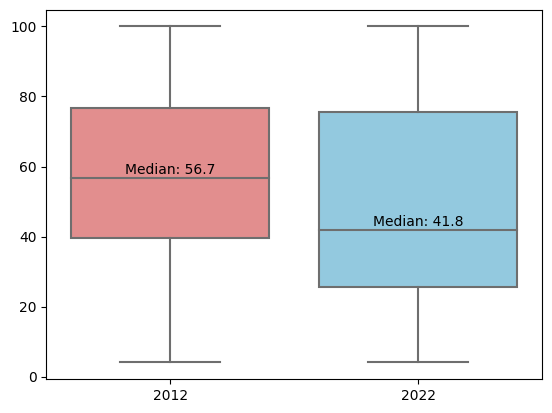

In [257]:
colors = ['lightcoral', 'skyblue']
data = poverty_2012_2022[['pobre12', 'pobre22']]
ax = sns.boxplot(data=data, palette=colors)
ax.set_xticklabels(['2012', '2022'])

# Add labels with mean and median values
median_val = data.median()
for i, col in enumerate(data.columns):
    plt.text(i, median_val[col] + 0.5, f'Median: {median_val[col]:.1f}', ha='center', va='bottom', color='black')

plt.show()


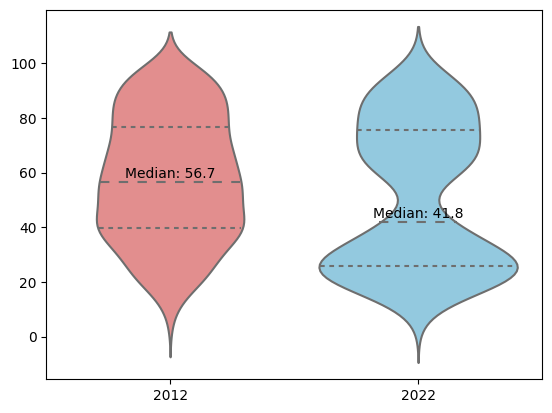

In [258]:
colors = ['lightcoral', 'skyblue']
data = poverty_2012_2022[['pobre12', 'pobre22']]
ax = sns.violinplot(data=data, palette=colors, inner='quartile')
ax.set_xticklabels(['2012', '2022'])

# Add labels with mean and median values
median_val = data.median()
for i, col in enumerate(data.columns):
    plt.text(i, median_val[col] + 0.5, f'Median: {median_val[col]:.1f}', ha='center', va='bottom', color='black')

plt.show()


<ipython-input-259-007fba00ac67>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Community is less poor?'] = np.where(data['diff'] < 0, "Yes", "No")


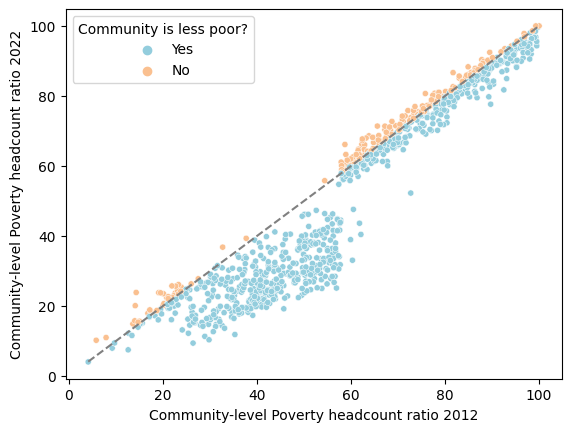

In [259]:
colors = ['#93CDDD', '#FAC090']
data = poverty_2012_2022[['pobre12', 'pobre22', 'diff']]
data['Community is less poor?'] = np.where(data['diff'] < 0, "Yes", "No")

ax = sns.scatterplot(data=data, x='pobre12', y='pobre22', hue='Community is less poor?', palette=colors, s=20)
ax.plot([min(data['pobre12']), max(data['pobre12'])], [min(data['pobre12']), max(data['pobre12'])], linestyle='--', color='gray')

ax.set_xlabel('Community-level Poverty headcount ratio 2012')
ax.set_ylabel('Community-level Poverty headcount ratio 2022')

plt.show()


In [264]:
poverty_2012_2022.groupby("depto").agg(
    count=pd.NamedAgg(column="pobre12", aggfunc="count"),
    mean_2012=pd.NamedAgg(column="pobre12", aggfunc="mean"),
    p25_2012=pd.NamedAgg(column="pobre12", aggfunc=lambda x: x.quantile(0.25)),
    median_2012=pd.NamedAgg(column="pobre12", aggfunc="median"),
    p75_2012=pd.NamedAgg(column="pobre12", aggfunc=lambda x: x.quantile(0.75)),
    mean_2022=pd.NamedAgg(column="pobre22", aggfunc="mean"),
    p25_2022=pd.NamedAgg(column="pobre22", aggfunc=lambda x: x.quantile(0.25)),
    median_2022=pd.NamedAgg(column="pobre22", aggfunc="median"),
    p75_2022=pd.NamedAgg(column="pobre22", aggfunc=lambda x: x.quantile(0.75))
    ).sort_values('median_2022')


,count,mean_2012,p25_2012,median_2012,p75_2012,mean_2022,p25_2022,median_2022,p75_2022
depto,,,,,,,,,
Chuquisaca,59,49.555932,31.550,41.70,70.300,42.194068,22.4450,26.760,69.1350
Potosi,86,47.960465,25.875,43.00,67.000,41.439535,21.1625,28.730,65.7075
Tarija,67,46.189552,28.150,45.90,58.300,37.887910,22.0100,29.280,56.7650
Beni,25,58.704000,49.600,56.30,71.100,49.882000,30.9300,38.950,71.8600
Cochabamba,174,58.194828,39.825,54.85,75.200,50.902816,26.0200,39.390,74.6025
Santa Cruz,237,56.948523,42.000,56.10,70.900,49.242278,27.0800,41.600,71.1200
Pando,11,57.827273,35.550,56.00,76.300,48.845455,28.1950,42.730,70.4200
La Paz,246,65.304878,49.875,67.80,83.100,59.567724,30.8225,66.645,81.5300
Oruro,48,62.725000,41.000,67.90,84.425,57.183125,26.0800,67.010,82.6625


In [260]:
poverty_2012_2022.to_excel("poverty_2012_2022.xlsx")

## **5. Feature importance**

In [261]:
# merge all data frames on 'feat' variable
feature_importance_all = pd.merge(feature_importance_ridge, feature_importance_lasso, on='feat', how='outer')
feature_importance_all = pd.merge(feature_importance_all, feature_importance_en, on='feat', how='outer')
feature_importance_all = pd.merge(feature_importance_all, feature_importance_dt, on='feat', how='outer')
feature_importance_all = pd.merge(feature_importance_all, feature_importance_ada, on='feat', how='outer')
feature_importance_all = pd.merge(feature_importance_all, feature_importance_gbr, on='feat', how='outer')
feature_importance_all = pd.merge(feature_importance_all, feature_importance_rf, on='feat', how='outer')
feature_importance_all = pd.merge(feature_importance_all, feature_importance_et, on='feat', how='outer')
feature_importance_all

,feat,imp_ridge,imp_lasso,imp_en,imp_dt,imp_ada,imp_gbr,imp_rf,imp_et
0,cp,0.403601,0.356960,0.395230,0.000000,0.007542,0.003638,0.005535,0.117181
1,schools,0.211721,0.195435,0.206575,0.151763,0.069152,0.154975,0.136879,0.270872
2,ci,0.186444,0.151804,0.179956,0.000000,0.001921,0.000440,0.000833,0.042419
3,primary,0.094138,0.083596,0.095666,0.000000,0.027646,0.015675,0.018609,0.025768
4,luz_mean,0.067008,0.043975,0.068342,0.001556,0.044772,0.010419,0.033901,0.038112
5,crops,0.033117,0.000000,0.031041,0.000000,0.006870,0.001838,0.005246,0.010271
6,hospitals,0.000000,0.000000,0.000000,0.000000,0.006505,0.001537,0.003950,0.020655
7,banks,0.000000,0.000000,0.000000,0.843338,0.758250,0.789185,0.736758,0.393707
8,zonurb,0.000000,0.000000,0.000000,0.003342,0.008690,0.003692,0.007995,0.016073
9,asenta,0.000000,0.000000,0.000000,0.000000,0.004581,0.003717,0.004069,0.011690


In [262]:
feature_importance_all.to_excel("feature_importance_all.xlsx")

## **6. Otros resultados**

In [ ]:
!pip install geopandas
import geopandas as gpd

In [ ]:
polygons = gpd.read_file('/content/drive/MyDrive/Research/Tesis UASB/FinalGIS/extension_comus_final.shp')
polygons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fid         953 non-null    float64 
 1   id          953 non-null    float64 
 2   departamen  953 non-null    object  
 3   provincia   953 non-null    object  
 4   municipio   953 non-null    object  
 5   codcomunid  953 non-null    float64 
 6   nombrecomu  953 non-null    object  
 7   id_unico    953 non-null    object  
 8   censo       953 non-null    object  
 9   codcenso    953 non-null    float64 
 10  lat         953 non-null    float64 
 11  long        953 non-null    float64 
 12  comunidad   953 non-null    object  
 13  pob_emp     953 non-null    float64 
 14  pob_estud   953 non-null    float64 
 15  hogares     953 non-null    float64 
 16  nopobre     953 non-null    float64 
 17  pobre       953 non-null    float64 
 18  count       953 non-null    int64   
 19  

In [ ]:
aux2 = ['codcomunid', 'count', 'geometry']
poly_2 = polygons[aux2]

In [ ]:
poly_avance = poly_2.merge(poverty_2012_2022, how='inner', left_on='codcomunid', right_on='codcomu')

In [ ]:
poly_avance.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 953 entries, 0 to 952
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   codcomunid  953 non-null    float64 
 1   count       953 non-null    int64   
 2   geometry    953 non-null    geometry
 3   codcomu     953 non-null    int64   
 4   depto       953 non-null    object  
 5   provincia   953 non-null    object  
 6   municipio   953 non-null    object  
 7   comunidad   953 non-null    object  
 8   pobre12     953 non-null    float64 
 9   pobre22     953 non-null    float64 
 10  diff        953 non-null    float64 
dtypes: float64(4), geometry(1), int64(2), object(4)
memory usage: 89.3+ KB


In [ ]:
poly_avance.to_file('/content/drive/My Drive/poligonos_poverty_2012_2022.shp')